# Query expansion
**Task**: Improve search performances by exploiting relevance feedback

- Get pseudo-feedback from query results
- Calculate average vector for *relevant* and *non relevant* documents in the pseudo-feedback
- Use Rocchio for expanding the query
- Calculate performances of the expanded query

In [4]:
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

**Embedding docs and search**

In [5]:
dataset_file = '../data/wiki_dataset.json'
with open(dataset_file, 'r') as infile:
    dataset = json.load(infile)
docs = dataset['docs']
queries = dataset['queries']
nlp = spacy.load("en_core_web_sm")
tokens = lambda text: [x.lemma_ for x in nlp(text) if x.pos_ not in ['PUNCT', 'SPACE'] and not x.is_stop]

In [6]:
V = CountVectorizer()
tf_idf = TfidfTransformer(use_idf=True)

In [7]:
pseudo_docs = [" ".join(tokens(doc)) for doc in docs]

In [8]:
X = tf_idf.fit_transform(V.fit_transform(pseudo_docs))

In [9]:
X.shape

(3128, 22031)

### Process queries

In [10]:
query_texts = [(query, " ".join(tokens(query))) for query in queries.keys()]

In [11]:
q_matrix = tf_idf.transform(V.transform([y for x, y in query_texts]))

In [12]:
q_matrix

<29x22031 sparse matrix of type '<class 'numpy.float64'>'
	with 62 stored elements in Compressed Sparse Row format>

In [13]:
q_index = 11
query_texts[q_index]

('democratic party (united states)', 'democratic party united state')

**Matching the original data**

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
matching = cosine_similarity(q_matrix, X)

In [16]:
matching.shape

(29, 3128)

## Get pseudo feedback
Since we do not have a real user feedback and it is not fair to use the ground truth as a feedback, we create a pseudo feedback by assuming that the **top k** results of our system are indeed **correct** and the **bottom z** results are wrong.

Then, giving $C_k$ and $N_z$ a the sets of correct and not correct results, respectively, we calculate the averate vectors $\vec{c_k}$ and $\vec{n_z}$ corresponding to the two sets. 

In [31]:
q_index = 10
query_texts[q_index]
print(query_texts[q_index])

('republican party (united states)', 'republican party united state')


In [32]:
answers = [(x, y) for x, y in sorted(enumerate(matching[q_index]), key=lambda x: -x[1])]
expected = set(queries[query_texts[q_index][0]])
k, z = 10, 200

### Evaluate the query

In [33]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

y_true, y_scores = [], []
for answer, score in answers:
    y_scores.append(score)
    if answer in expected:
        y_true.append(1)
    else:
        y_true.append(0)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

### Calculate pseudo-feedback centroids

In [34]:
C_k, N_z = X[[x for x, y in answers[:k]]], X[[x for x, y in answers[-z:]]]

In [35]:
print(C_k.shape, N_z.shape)

(10, 22031) (200, 22031)


In [36]:
c_k, n_z = np.asarray(C_k.mean(axis=0))[0], np.asarray(N_z.mean(axis=0))[0]

### Visualize

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

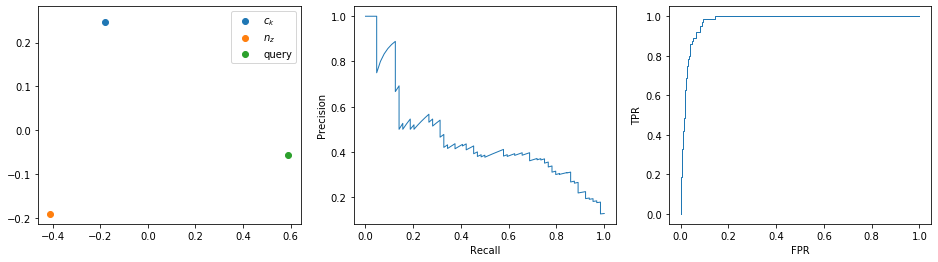

In [37]:
pca = PCA(n_components=2)
centroids = np.array([c_k, n_z, q_matrix[q_index].toarray()[0]])
visual = pca.fit_transform(centroids)

fig, ax = plt.subplots(figsize=(16, 4), nrows=1, ncols=3)
ax[0].scatter(visual[0,0], visual[0,1], label='$c_k$')
ax[0].scatter(visual[1,0], visual[1,1], label='$n_z$')
ax[0].scatter(visual[2,0], visual[2,1], label='query')
ax[1].plot(recall, precision, linewidth=1)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[2].plot(fpr, tpr, linewidth=1)
ax[2].set_xlabel('FPR')
ax[2].set_ylabel('TPR')
ax[0].legend()
plt.show()

## Rocchio
The idea of Rocchio algorithm is to push the query towards the (pseudo-) correct results and away from the non correct ones.

$$
\vec{q}_{o} = \alpha \vec{q} + \beta \frac{1}{\mid C_{r} \mid}
\sum_{\vec{d_{j}} \in C_{r}} \vec{d_{j}} -
\gamma \frac{1}{\mid C_{nr} \mid}
\sum_{\vec{d_{j}} \in C_{nr}} \vec{d_{j}}
$$

In [38]:
alpha, beta, gamma = 0.5, 0.75, 0.75
q = q_matrix[q_index].toarray()[0]

In [39]:
q_e = alpha * q + beta * c_k - gamma * n_z

### Evaluate the new query

In [40]:
q_e_matching = cosine_similarity(q_e.reshape(1, -1), X)
q_e_answers = [(x, y) for x, y in sorted(enumerate(q_e_matching[0]), key=lambda x: -x[1])]
q_e_y_true, q_e_y_scores = [], []
for answer, score in q_e_answers:
    q_e_y_scores.append(score)
    if answer in expected:
        q_e_y_true.append(1)
    else:
        q_e_y_true.append(0)
q_e_precision, q_e_recall, q_e_thresholds = precision_recall_curve(q_e_y_true, q_e_y_scores)
q_e_fpr, q_e_tpr, q_e_thresholds = roc_curve(q_e_y_true, q_e_y_scores)

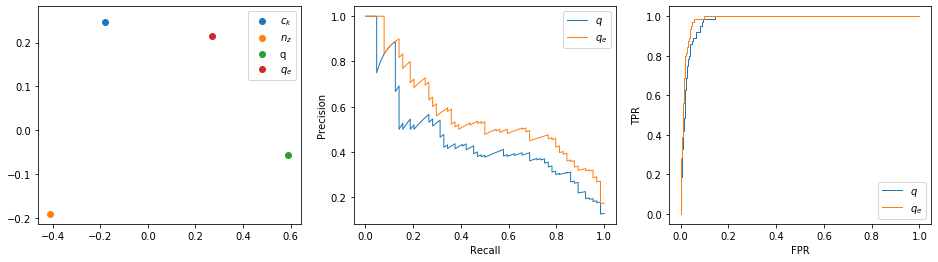

In [41]:
centroids = np.array([c_k, n_z, q])
q_e_visual = pca.transform(q_e.reshape(1, -1))

fig, ax = plt.subplots(figsize=(16, 4), nrows=1, ncols=3)
ax[0].scatter(visual[0,0], visual[0,1], label='$c_k$')
ax[0].scatter(visual[1,0], visual[1,1], label='$n_z$')
ax[0].scatter(visual[2,0], visual[2,1], label='q')
ax[0].scatter(q_e_visual[0,0], q_e_visual[0,1], label='$q_e$')
ax[1].plot(recall, precision, linewidth=1, label='$q$')
ax[1].plot(q_e_recall, q_e_precision, linewidth=1, label='$q_e$')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()
ax[2].plot(fpr, tpr, linewidth=1, label='$q$')
ax[2].plot(q_e_fpr, q_e_tpr, linewidth=1, label='$q_e$')
ax[2].set_xlabel('FPR')
ax[2].set_ylabel('TPR')
ax[2].legend()
ax[0].legend()
plt.show()